## Initialization

In [17]:
import numpy as np
import matplotlib.pyplot as plt

from dataclasses import dataclass
from typing import List, Literal, Tuple


@dataclass
class Parameter:
    name: str
    data: np.ndarray
    grad: np.ndarray


class Module:
    def __call__(self, *args, **kwargs):
        return self.forward(*args, **kwargs)
        
    def forward(self, *args, **kwargs):
        raise NotImplementedError

    def backward(self, *args, **kwargs):
        raise NotImplementedError
    
    def parameters(self) -> List[Parameter]:
        return []

    def zero_grad(self):
        for param in self.parameters():
            param.grad.fill(0)


# Define a custom type alias for initialization methods
InitMethod = Literal["xavier", "he", "he_leaky", "normal", "uniform"]

def parameter(
    input_size: int,
    output_size: int,
    init_method: InitMethod = "xavier",
    gain: float = 1,
    alpha: float = 0.01
) -> np.ndarray:
    weights = np.random.randn(input_size, output_size)

    if init_method == "xavier":
        std = gain * np.sqrt(1.0 / input_size)
        return std * weights
    if init_method == "he":
        std = gain * np.sqrt(2.0 / input_size)
        return std * weights
    if init_method == "he_leaky":
        std = gain * np.sqrt(2.0 / (1 + alpha**2) * (1 / input_size))
        return std * weights
    if init_method == "normal":
        return gain * weights
    if init_method == "uniform":
        return gain * np.random.uniform(-1, 1, size=(input_size, output_size))

    raise ValueError(f"Unknown initialization method: {init_method}")


class Linear(Module):
    def __init__(
        self,
        input_size: int,
        output_size: int,
        init_method: InitMethod = "xavier"
    ):
        self.input: np.ndarray = None

        self.weights: np.ndarray = parameter(input_size, output_size, init_method)
        self.d_weights: np.ndarray = np.zeros_like(self.weights)

        self.biases: np.ndarray = np.zeros((1, output_size))
        self.d_biases: np.ndarray = np.zeros_like(self.biases)

    def forward(self, x: np.ndarray) -> np.ndarray:
        self.input = x
        x1 = x @ self.weights + self.biases
        return x1
    
    def backward(self, d_out: np.ndarray) -> np.ndarray:
        self.d_weights = self.input.T @ d_out
        self.d_biases = np.sum(d_out, axis=0, keepdims=True)

        return d_out @ self.weights.T

    def parameters(self):
        return [
            Parameter(
                name="weights",
                data=self.weights,
                grad=self.d_weights
            ),
            Parameter(
                name="biases",
                data=self.biases,
                grad=self.d_biases
            ),
        ]


class BCELoss(Module):
    def forward(
        self, pred: np.ndarray, target: np.ndarray, epsilon: float = 1e-7
    ) -> np.ndarray:        
        loss = -(
            target * np.log(pred + epsilon) + 
            (1 - target) * np.log(1 - pred + epsilon)
        )

        return np.mean(loss)

    def backward(
        self, pred: np.ndarray, target: np.ndarray, epsilon: float = 1e-7
    ) -> np.ndarray:
        grad = (pred - target) / (pred * (1 - pred) + epsilon)
        return grad


class Sigmoid(Module):
    def forward(self, x: np.ndarray):
        # Apply the Sigmoid function element-wise
        self.output = 1 / (1 + np.exp(-x))
        return self.output

    def backward(self, d_out: np.ndarray):
        # Derivative of the Sigmoid function: sigmoid * (1 - sigmoid)
        ds = self.output * (1 - self.output)
        return d_out * ds


class LeakyReLU(Module):
    def __init__(self, alpha: float = 0.01):
        self.alpha = alpha

    def forward(self, x: np.ndarray):
        self.input = x
        return np.where(x > 0, x, self.alpha * x)

    def backward(self, d_out: np.ndarray):
        dx = np.ones_like(self.input)
        dx[self.input < 0] = self.alpha
        return d_out * dx


class Sequential(Module):
    def __init__(self, layers: List[Module]):
        self.layers = layers

    def forward(self, x: np.ndarray) -> np.ndarray:
        for layer in self.layers:
            x = layer.forward(x)
        return x

    def backward(self, d_out: np.ndarray, lr: float = 0.001) -> np.ndarray:
        for layer in reversed(self.layers):
            d_out = layer.backward(d_out)
        return d_out

    def parameters(self) -> List[Parameter]:
        params = []
        for i, layer in enumerate(self.layers):
            for param in layer.parameters():
                # Add unique prefix name for optimization step
                param.name = f"layer_{i}_{param.name}"
                params.append(param)
        return params


def make_spiral_dataset(
    n_samples: int = 100,
    noise: float = 0.2,
    seed: int = None,
    x_range: Tuple[int, int] = (-1, 1),
    y_range: Tuple[int, int] = (-1, 1)
):
    # Install the random seed
    if seed:
        np.random.seed(seed)

    n = n_samples // 2  # Split samples between two spirals

    # Generate first spiral
    theta1 = np.sqrt(np.random.rand(n)) * 4 * np.pi
    r1 = 2 * theta1 + np.pi
    x1 = np.stack([r1 * np.cos(theta1), r1 * np.sin(theta1)], axis=1)

    # Generate second spiral
    theta2 = np.sqrt(np.random.rand(n)) * 4 * np.pi
    r2 = -2 * theta2 - np.pi
    x2 = np.stack([r2 * np.cos(theta2), r2 * np.sin(theta2)], axis=1)

    # Combine spirals and add noise
    X = np.vstack([x1, x2])
    X += np.random.randn(n_samples, 2) * noise

    # Scale X to fit within the specified x and y ranges
    X[:, 0] = np.interp(X[:, 0], (X[:, 0].min(), X[:, 0].max()), x_range)
    X[:, 1] = np.interp(X[:, 1], (X[:, 1].min(), X[:, 1].max()), y_range)

    # Create labels
    y_range = np.zeros(n_samples)
    y_range[:n] = 0  # First spiral
    y_range[n:] = 1  # Second spiral

    return X, y_range


# Define function for plotting decision boundaries
def plot_decision_boundaries(model, X, y, bins=500):
    # Set the limits of the plot
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1

    # Generate a grid of points
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, bins), np.linspace(y_min, y_max, bins))
    grid = np.c_[xx.ravel(), yy.ravel()]

    # Get the predicted class for each point in the grid
    Z = model.forward(grid)  # Only get the predicted output
    Z = (Z > 0.5).astype(int)  # Assuming binary classification

    # Reshape the predictions back to the grid shape
    Z = Z.reshape(xx.shape)

    # Plot the decision boundary
    plt.contourf(xx, yy, Z, alpha=0.8, cmap='coolwarm')
    plt.scatter(X[:, 0], X[:, 1], c=y.ravel(), edgecolors='k', marker='o', s=30, label='Data Points')
    plt.title('Decision Boundary')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    plt.colorbar()
    plt.tight_layout()
    plt.grid(True)
    plt.show()


## Generate synthetic classification data

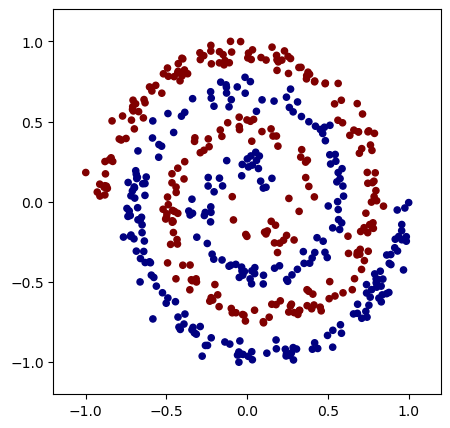

In [18]:
n_samples = 500

x, y_target = make_spiral_dataset(n_samples=n_samples, noise=1.2, seed=1)
y_target = y_target.reshape(-1, 1)

# visualize in 2D
plt.figure(figsize=(5, 5))
plt.scatter(x[:, 0], x[:, 1], c=y_target, s=20, cmap="jet")
plt.xlim(x[:, 0].min() - 0.2, x[:, 0].max() + 0.2)
plt.ylim(x[:, 1].min() - 0.2, x[:, 1].max() + 0.2)
plt.show()

## SGD: demo "momentum"

In [19]:
class SGD:
    def __init__(
        self,
        lr: float = 0.01,
        momentum: float = 0.0
    ):
        self.lr = lr
        self.momentum = momentum
        self.velocity = {}

    def step(self, module: Module):
        for param in module.parameters():
            param_id = param.name

            # Init velocity if not exists
            if param_id not in self.velocity:
                self.velocity[param_id] = np.zeros_like(param.data)

            grad = param.grad.copy()

            # Update momentum
            self.velocity[param_id] = self.momentum * self.velocity[param_id] - self.lr * grad

            # Update parameters
            param.data += self.velocity[param_id]

## Training loop creator:

In [20]:
def train_model(
    model: Module,
    loss_f: Module,
    optimizer,
    n_epochs: int = 500
):
    for epoch in range(n_epochs):
        # Forward
        y_pred = model(x)
        loss = loss_f(y_pred, y_target)

        model.zero_grad() 

        # Backward
        grad = loss_f.backward(y_pred, y_target)
        model.backward(grad)

        optimizer.step(model)

        print(f"Epoch {epoch}, Loss: {loss:.4f}")

## Example: SGD Epic Fail!

In [21]:
# Model architecture
model = Sequential([
    Linear(x.shape[1], 128, init_method="he_leaky"),
    LeakyReLU(alpha=0.01),
    Linear(128, 64, init_method="he_leaky"),
    LeakyReLU(alpha=0.01),
    Linear(64, 1, init_method="xavier"),
    Sigmoid()
])

bce = BCELoss()
optimizer = SGD(lr=0.01, momentum=0.9)

# Training: SGD Epic Fail!
train_model(model, bce, optimizer, n_epochs=100)

Epoch 0, Loss: 0.7288
Epoch 1, Loss: 1.9891
Epoch 2, Loss: 7.4436
Epoch 3, Loss: 6.4521
Epoch 4, Loss: 4.3288
Epoch 5, Loss: 4.3210
Epoch 6, Loss: 0.9080
Epoch 7, Loss: 1.5553
Epoch 8, Loss: 4.7248
Epoch 9, Loss: 1.8433
Epoch 10, Loss: 8.0587
Epoch 11, Loss: 8.0590
Epoch 12, Loss: 8.0590
Epoch 13, Loss: 8.0590
Epoch 14, Loss: 8.0590
Epoch 15, Loss: 8.0590
Epoch 16, Loss: 8.0590
Epoch 17, Loss: 8.0590
Epoch 18, Loss: 8.0590
Epoch 19, Loss: 8.0590
Epoch 20, Loss: 8.0590
Epoch 21, Loss: 8.0590
Epoch 22, Loss: 8.0590
Epoch 23, Loss: 8.0590
Epoch 24, Loss: 8.0590
Epoch 25, Loss: 8.0590
Epoch 26, Loss: 8.0590
Epoch 27, Loss: 8.0590
Epoch 28, Loss: 8.0590
Epoch 29, Loss: 8.0590
Epoch 30, Loss: 8.0590
Epoch 31, Loss: 8.0590
Epoch 32, Loss: 8.0590
Epoch 33, Loss: 8.0590
Epoch 34, Loss: 8.0590
Epoch 35, Loss: 8.0590
Epoch 36, Loss: 8.0590
Epoch 37, Loss: 8.0590
Epoch 38, Loss: 8.0590
Epoch 39, Loss: 8.0590
Epoch 40, Loss: 8.0590
Epoch 41, Loss: 8.0590
Epoch 42, Loss: 8.0590
Epoch 43, Loss: 8.059

C:\Users\oaiw\AppData\Local\Temp\ipykernel_17492\1697699738.py:124: RuntimeWarning: overflow encountered in exp
  self.output = 1 / (1 + np.exp(-x))


## SGD and Momentum, again!

$$v_{t+1} = \mu \cdot v_{t} - \alpha \nabla f(x_t)$$

The update rule for our position becomes:

$$x_{t+1} = x_t + v_{t+1}$$

## SGD: correct momentum

$$v_{t+1} = \mu \cdot v_{t} + (1 - \mu) \nabla f(x_t)$$

The update rule for our position, where $\alpha$ is the step size, is:

$$x_{t+1} = x_t - \alpha \cdot v_{t+1}$$

In the correct implementation, we use **both** terms in the **negative direction.**

In [22]:
class SGD:
    def __init__(
        self,
        lr: float = 0.01,
        momentum: float = 0.0
    ):
        self.lr = lr
        self.momentum = momentum
        self.velocity = {}

    def step(self, module: Module):
        for param in module.parameters():
            param_id = param.name

            # Init velocity if not exists
            if param_id not in self.velocity:
                self.velocity[param_id] = np.zeros_like(param.data)

            grad = param.grad.copy()

            # Update momentum
            self.velocity[param_id] = (
                self.momentum * self.velocity[param_id] +
                (1 - self.momentum) * grad
            )

            # Update parameters
            param.data -= self.lr * self.velocity[param_id]

In [25]:
# Recreate Model, BCE, optimizer
model = Sequential([
    Linear(x.shape[1], 128, init_method="he_leaky"),
    LeakyReLU(alpha=0.01),
    Linear(128, 64, init_method="he_leaky"),
    LeakyReLU(alpha=0.01),
    Linear(64, 1, init_method="xavier"),
    Sigmoid()
])

bce = BCELoss()
optimizer = SGD(lr=0.01, momentum=0.9)

train_model(model, bce, optimizer, n_epochs=500)

Epoch 0, Loss: 0.7023
Epoch 1, Loss: 0.6343
Epoch 2, Loss: 0.6479
Epoch 3, Loss: 0.6560
Epoch 4, Loss: 0.6377
Epoch 5, Loss: 0.6282
Epoch 6, Loss: 0.6342
Epoch 7, Loss: 0.6373
Epoch 8, Loss: 0.6352
Epoch 9, Loss: 0.6288
Epoch 10, Loss: 0.6214
Epoch 11, Loss: 0.6189
Epoch 12, Loss: 0.6202
Epoch 13, Loss: 0.6205
Epoch 14, Loss: 0.6174
Epoch 15, Loss: 0.6126
Epoch 16, Loss: 0.6097
Epoch 17, Loss: 0.6098
Epoch 18, Loss: 0.6103
Epoch 19, Loss: 0.6091
Epoch 20, Loss: 0.6064
Epoch 21, Loss: 0.6034
Epoch 22, Loss: 0.6018
Epoch 23, Loss: 0.6011
Epoch 24, Loss: 0.5999
Epoch 25, Loss: 0.5983
Epoch 26, Loss: 0.5966
Epoch 27, Loss: 0.5950
Epoch 28, Loss: 0.5930
Epoch 29, Loss: 0.5906
Epoch 30, Loss: 0.5891
Epoch 31, Loss: 0.5875
Epoch 32, Loss: 0.5852
Epoch 33, Loss: 0.5829
Epoch 34, Loss: 0.5805
Epoch 35, Loss: 0.5779
Epoch 36, Loss: 0.5745
Epoch 37, Loss: 0.5714
Epoch 38, Loss: 0.5693
Epoch 39, Loss: 0.5651
Epoch 40, Loss: 0.5622
Epoch 41, Loss: 0.5595
Epoch 42, Loss: 0.5554
Epoch 43, Loss: 0.552

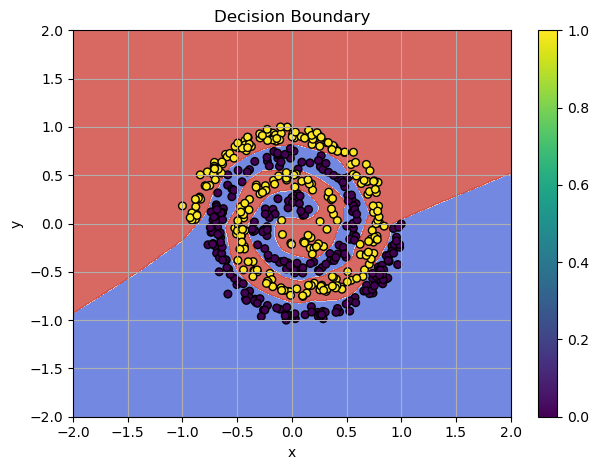

In [27]:
plot_decision_boundaries(model, x, y_target)

## Exploding gradients


$$v_{t+1} = \mu \cdot v_{t} + (1 - \mu) \nabla f(x_t)$$

Update rule:

$$x_{t+1} = x_t - \alpha \cdot v_{t+1}$$

$$x_{t+1} = x_t - \alpha (\mu \cdot v_{t} + (1 - \mu) \nabla f(x_t))$$

Let's use the $\alpha=0.1$ and the same $\mu=0.9$:

$$x_{t+1} = x_t - 0.1 \cdot (0.9 \cdot v_t - 0.1 \cdot \nabla f(x_t))$$

In [28]:
# Recreate Model, BCE, optimizer
model = Sequential([
    Linear(x.shape[1], 128, init_method="he_leaky"),
    LeakyReLU(alpha=0.01),
    Linear(128, 64, init_method="he_leaky"),
    LeakyReLU(alpha=0.01),
    Linear(64, 1, init_method="xavier"),
    Sigmoid()
])

bce = BCELoss()
optimizer = SGD(lr=0.1, momentum=0.9)

# Training: SGD Epic Fail for lr=0.1!
train_model(model, bce, optimizer, n_epochs=500)

Epoch 0, Loss: 0.6648
Epoch 1, Loss: 1.0686
Epoch 2, Loss: 1.3645
Epoch 3, Loss: 1.8601
Epoch 4, Loss: 7.5886
Epoch 5, Loss: 6.4479
Epoch 6, Loss: 4.6624
Epoch 7, Loss: 5.2808
Epoch 8, Loss: 2.4018
Epoch 9, Loss: 5.3229
Epoch 10, Loss: 8.0590
Epoch 11, Loss: 8.0590
Epoch 12, Loss: 8.0590
Epoch 13, Loss: 8.0590
Epoch 14, Loss: 8.0590
Epoch 15, Loss: 8.0590
Epoch 16, Loss: 8.0590
Epoch 17, Loss: 8.0590
Epoch 18, Loss: 8.0590
Epoch 19, Loss: 8.0590
Epoch 20, Loss: 8.0590
Epoch 21, Loss: 8.0590
Epoch 22, Loss: 8.0590
Epoch 23, Loss: 8.0590
Epoch 24, Loss: 8.0590
Epoch 25, Loss: 8.0590
Epoch 26, Loss: 8.0590
Epoch 27, Loss: 8.0590
Epoch 28, Loss: 8.0590
Epoch 29, Loss: 8.0590
Epoch 30, Loss: 8.0590
Epoch 31, Loss: 8.0590
Epoch 32, Loss: 8.0590
Epoch 33, Loss: 8.0590
Epoch 34, Loss: 8.0590
Epoch 35, Loss: 8.0590
Epoch 36, Loss: 8.0590
Epoch 37, Loss: 8.0590
Epoch 38, Loss: 8.0590
Epoch 39, Loss: 8.0590
Epoch 40, Loss: 8.0590
Epoch 41, Loss: 8.0590
Epoch 42, Loss: 8.0590
Epoch 43, Loss: 8.059

## Gradient Clipping

It limits the size of the gradients to a min/max range:

$$\nabla \mathcal{L} \leftarrow \text{clip}(\nabla \mathcal{L}, -\text{clip\_value}, \text{clip\_value})$$


In [29]:
class SGD:
    def __init__(
        self,
        lr: float = 0.01,
        momentum: float = 0.0,
        clip_value: float = 1.0
    ):
        self.lr = lr
        self.momentum = momentum
        self.clip_value = clip_value
        self.velocity = {}

    def step(self, module: Module):
        for param in module.parameters():
            param_id = param.name

            # Init velocity if not exists
            if param_id not in self.velocity:
                self.velocity[param_id] = np.zeros_like(param.data)

            grad = param.grad.copy()

            # Gradient cliping
            if self.clip_value > 0:
                np.clip(grad, -self.clip_value, self.clip_value, out=grad)

            # Update momentum
            self.velocity[param_id] = (
                self.momentum * self.velocity[param_id] +
                (1 - self.momentum) * grad
            )

            # Update parameters
            param.data -= self.lr * self.velocity[param_id]

In [30]:
# Recreate Model, BCE, optimizer
model = Sequential([
    Linear(x.shape[1], 128, init_method="he_leaky"),
    LeakyReLU(alpha=0.01),
    Linear(128, 64, init_method="he_leaky"),
    LeakyReLU(alpha=0.01),
    Linear(64, 1, init_method="xavier"),
    Sigmoid()
])

bce = BCELoss()
optimizer = SGD(lr=0.1, momentum=0.9)

# Training
train_model(model, bce, optimizer, n_epochs=100)

Epoch 0, Loss: 0.7059
Epoch 1, Loss: 0.6388
Epoch 2, Loss: 0.6508
Epoch 3, Loss: 0.6286
Epoch 4, Loss: 0.6698
Epoch 5, Loss: 0.6480
Epoch 6, Loss: 0.6477
Epoch 7, Loss: 0.6540
Epoch 8, Loss: 0.6322
Epoch 9, Loss: 0.6153
Epoch 10, Loss: 0.6264
Epoch 11, Loss: 0.6120
Epoch 12, Loss: 0.6179
Epoch 13, Loss: 0.6102
Epoch 14, Loss: 0.6036
Epoch 15, Loss: 0.6111
Epoch 16, Loss: 0.6071
Epoch 17, Loss: 0.5967
Epoch 18, Loss: 0.5880
Epoch 19, Loss: 0.5954
Epoch 20, Loss: 0.5792
Epoch 21, Loss: 0.6102
Epoch 22, Loss: 0.5999
Epoch 23, Loss: 0.5843
Epoch 24, Loss: 0.5960
Epoch 25, Loss: 0.5558
Epoch 26, Loss: 0.5771
Epoch 27, Loss: 0.5767
Epoch 28, Loss: 0.5426
Epoch 29, Loss: 0.5398
Epoch 30, Loss: 0.5117
Epoch 31, Loss: 0.5274
Epoch 32, Loss: 0.5191
Epoch 33, Loss: 0.4993
Epoch 34, Loss: 0.5077
Epoch 35, Loss: 0.4896
Epoch 36, Loss: 0.4699
Epoch 37, Loss: 0.4635
Epoch 38, Loss: 0.4253
Epoch 39, Loss: 0.4357
Epoch 40, Loss: 0.3998
Epoch 41, Loss: 0.4500
Epoch 42, Loss: 0.4132
Epoch 43, Loss: 0.394

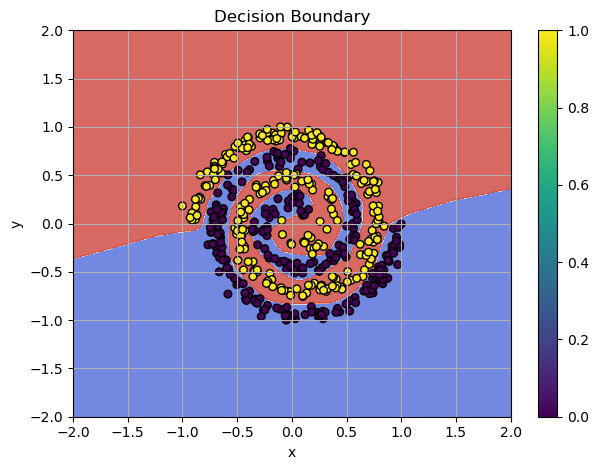

In [31]:
plot_decision_boundaries(model, x, y_target)